In [4]:
import os
import pandas as pd
import time
import json

import numpy as np
from tqdm import tqdm
#from skimage.io import imread, imshow
#from skimage.transform import resize
import matplotlib.pyplot as plt
import datetime
import cv2
#Metricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
#%env SM_FRAMEWORK=tf.keras
# Librerias para constuir la arquitectura Deeplab
# Pretrained Model
from tensorflow.keras.applications import ResNet50
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Layer, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, Concatenate, MaxPool2D,BatchNormalization,UpSampling2D,AveragePooling2D,ReLU
from tensorflow.keras.models import Model,Sequential
#import segmentation_models as sm
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

from tensorflow.keras import backend as tf_backend

In [3]:
from google.colab import drive
drive.mount('/content/drive')
# Cambia el directorio de trabajo a la carpeta deseada
os.chdir('/content/drive/MyDrive')
os.listdir()

Mounted at /content/drive


['Colab Notebooks',
 'buildings_png',
 'build_models',
 'roads_png',
 'road_models',
 'road_build_models',
 'build_models_custom',
 'Multiclass_img',
 'road_models_custom',
 'Add']

In [5]:
from functions import from_hex2rgb, from_rgb2bgr, process_img,preprocess_list_with_crops,dice_multiv2,obtener_corte,reconstruir_imagen,color_to_2D_label,plot_images_comparation

In [7]:
data_path_images='../Img'
# Mostrar los datos cargados
dict_clases={}
i=0
# Cargar el archivo JSON
with open("../classes_corrected.json", "r") as archivo:
    datos_json = json.load(archivo)
for class_ in  datos_json['classes']:
    dict_clases[i]={'rgb':from_hex2rgb(class_['color']),'bgr':from_rgb2bgr(from_hex2rgb(class_['color'])),'name':class_['title'],'value':i}
    i+=1
for key in dict_clases:
    print(dict_clases[key]['name'],dict_clases[key]['rgb'],dict_clases[key]['bgr'],dict_clases[key]['value'])

Water [226 169  41] [ 41 169 226] 0
Land (unpaved area) [132  41 246] [246  41 132] 1
Road [110 193 228] [228 193 110] 2
Building [ 60  16 152] [152  16  60] 3
Vegetation [254 221  58] [ 58 221 254] 4
Unlabeled [155 155 155] [155 155 155] 5


In [8]:
labels,all_img=process_img(resize_=False,resize_shape=(224,224),dict_clases=dict_clases,data_path_images=data_path_images)

100%|██████████| 72/72 [00:09<00:00,  7.36it/s]

72 72


In [9]:
X_train, X_temp, y_train, y_temp = train_test_split(all_img, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Tamaño del conjunto de entrenamiento: {len(X_train)}")
print(f"Tamaño del conjunto de validación: {len(X_val)}")
print(f"Tamaño del conjunto de prueba: {len(X_test)}")

# Definir tamaño del recorte
crop_size = (224, 224)
numer_crops=40
# Preprocesar datos
X_train_cropped, y_train_cropped = preprocess_list_with_crops(X_train, y_train, crop_size,numer_crops=numer_crops)
X_val_cropped, y_val_cropped = preprocess_list_with_crops(X_val, y_val, crop_size,numer_crops=numer_crops)
X_test_cropped, y_test_cropped = preprocess_list_with_crops(X_test, y_test, crop_size,numer_crops=numer_crops)

print("Tamaños después del recorte:")
print("X_train:", X_train_cropped.shape, "y_train:", y_train_cropped.shape)
print("X_val:", X_val_cropped.shape, "y_val:", y_val_cropped.shape)
print("X_test:", X_test_cropped.shape, "y_test:", y_test_cropped.shape)

Tamaño del conjunto de entrenamiento: 57
Tamaño del conjunto de validación: 7
Tamaño del conjunto de prueba: 8


57it [00:07,  7.21it/s]
7it [00:01,  6.06it/s]
8it [00:01,  6.80it/s]

Tamaños después del recorte:
X_train: (2280, 224, 224, 3) y_train: (2280, 224, 224)
X_val: (280, 224, 224, 3) y_val: (280, 224, 224)
X_test: (320, 224, 224, 3) y_test: (320, 224, 224)


In [10]:
class ConvBlock(Layer):

    def __init__(self, filters=256, kernel_size=3, dilation_rate=1, **kwargs):
        super(ConvBlock, self).__init__(**kwargs)

        self.filters = filters
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate

        self.net = Sequential([
            Conv2D(filters, kernel_size=kernel_size, padding='same', dilation_rate=dilation_rate, use_bias=False, kernel_initializer='he_normal'),
            BatchNormalization(),
            ReLU()
        ])

    def call(self, X):
        return self.net(X)

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "kernel_size":self.kernel_size,
            "dilation_rate":self.dilation_rate,
        }
def AtrousSpatialPyramidPooling(X):
    B, H, W, C = X.shape

    # Image Pooling
    image_pool = AveragePooling2D(pool_size=(H, W), name="ASPP-AvgPool")(X)
    image_pool = ConvBlock(kernel_size=1, name="ASPP-ImagePool-CB")(image_pool)
    image_pool = UpSampling2D(size=(H//image_pool.shape[1], W//image_pool.shape[2]), name="ASPP-ImagePool-UpSample")(image_pool)

    # Atrous Oprtations
    conv_1  = ConvBlock(kernel_size=1, dilation_rate=1, name="ASPP-CB-1")(X)
    conv_6  = ConvBlock(kernel_size=3, dilation_rate=6, name="ASPP-CB-6")(X)
    conv_12 = ConvBlock(kernel_size=3, dilation_rate=12, name="ASPP-CB-12")(X)
    conv_18 = ConvBlock(kernel_size=3, dilation_rate=18, name="ASPP-CB-18")(X)

    # Combine All
    combined = Concatenate(name="ASPP-Combine")([image_pool, conv_1, conv_6, conv_12, conv_18])
    processed = ConvBlock(kernel_size=1, name="ASPP-Net")(combined)

    # Final Output
    return processed
# PARAM
LR = 1e-3
IMAGE_SIZE = 224

# Input
InputL = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="InputLayer")

# Base Mode
resnet50 = ResNet50(include_top=False, weights='imagenet', input_tensor=InputL)

# ASPP Phase
DCNN = resnet50.get_layer('conv4_block6_2_relu').output
ASPP = AtrousSpatialPyramidPooling(DCNN)
ASPP = UpSampling2D(size=(IMAGE_SIZE//4//ASPP.shape[1], IMAGE_SIZE//4//ASPP.shape[2]), name="AtrousSpatial")(ASPP)

# LLF Phase
LLF = resnet50.get_layer('conv2_block3_2_relu').output
LLF = ConvBlock(filters=48, kernel_size=1, name="LLF-ConvBlock")(LLF)

# Combined
combined = Concatenate(axis=-1, name="Combine-LLF-ASPP")([ASPP, LLF])
features = ConvBlock(name="Top-ConvBlock-1")(combined)
features = ConvBlock(name="Top-ConvBlock-2")(features)
upsample = UpSampling2D(size=(IMAGE_SIZE//features.shape[1], IMAGE_SIZE//features.shape[1]), interpolation='bilinear', name="Top-UpSample")(features)

# Output Mask
PredMask = Conv2D(6, kernel_size=3, strides=1, padding='same', activation='softmax', use_bias=False, name="OutputMask")(upsample)

# DeelLabV3+ Model
model = Model(InputL, PredMask, name="DeepLabV3-Plus")
#model.summary()

In [9]:
checkpoint = ModelCheckpoint(filepath='Multiclass_img/modelo_deeplab/modelo-{epoch:02d}-{val_accuracy:.2f}_v2.weights.h5',
                             monitor='val_accuracy',  # Puede ser 'val_accuracy' si prefieres
                             save_best_only=True,
                             save_weights_only=True,  # Para guardar toda la arquitectura y los pesos
                             mode='max',  # O 'max' si monitorizas 'accuracy'
                             verbose=1)

In [10]:
# Compile Model
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,metrics=[dice_multiv2,'accuracy'])

# Callback
#class ShowProgress(Callback):
#    def on_epoch_end(self, epoch, logs=None):
#        if (epoch+1)%5==0:
#            show_images(valid_ds, model=self.model, explain=True, n_images=5, SIZE=(15,8))

# Callbacks
#callbacks = [ModelCheckpoint("DeepLabV3-Plus.h5"), ShowProgress()]
t=50
v=5
# Training
history=model.fit(
        x=X_train_cropped[:],
        y=y_train_cropped[:],
        validation_data=(X_val_cropped[:],y_val_cropped[:]),
        epochs=25,
        callbacks=checkpoint
          )

Epoch 1/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7083 - dice_multiv2: 0.4969 - loss: 0.8488   
Epoch 1: val_accuracy improved from -inf to 0.24212, saving model to Multiclass_img/modelo_deeplab/modelo-01-0.24_v2.weights.h5
72/72 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.7093 - dice_multiv2: 0.4980 - loss: 0.8459 - val_accuracy: 0.2421 - val_dice_multiv2: 0.1811 - val_loss: 3.5484
Epoch 2/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - accuracy: 0.8433 - dice_multiv2: 0.6657 - loss: 0.4458
Epoch 2: val_accuracy improved from 0.24212 to 0.54311, saving model to Multiclass_img/modelo_deeplab/modelo-02-0.54_v2.weights.h5
72/72 ━━━━━━━━━━━━━━━━━━━━ 79s 732ms/step - accuracy: 0.8435 - dice_multiv2: 0.6659 - loss: 0.4454 - val_accuracy: 0.5431 - val_dice_multiv2: 0.3415 - val_loss: 1.1870
Epoch 3/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 677ms/step - accuracy: 0.8711 - dice_multiv2: 0.7401 - loss: 0.3543
Epoch 3: val_accuracy improved from 0.54311 to 0.72458, saving model to Multicla

In [ ]:
model.save_weights('Multiclass_img/modelo_deeplab/model_final_deeplab_v22.weights.h5')

In [18]:
#model_load=model
model.load_weights('Multiclass_img/modelo_deeplab/modelo-19-0.86_v2.weights.h5')
preds=model.predict(X_test_cropped[:])
#dice_test=dice_multiv2(y_test_cropped,preds)
#print('DICE test:',dice_test.numpy(),' ACC',np.mean(np.argmax(preds, axis=-1)==y_test_cropped))

dice_test=dice_multiv2(y_test_cropped[:],preds)
print('DICE test:',dice_test.numpy(),' ACC',np.mean(np.argmax(preds, axis=-1)==y_test_cropped))

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 296ms/step
DICE test: 0.73598903  ACC 0.8864662014708227


In [12]:
import json

# Guardar el history en un archivo JSON
with open('Multiclass_img/modelo_deeplab/history_deeplab_v222.json', 'w') as f:
    json.dump(history.history, f)

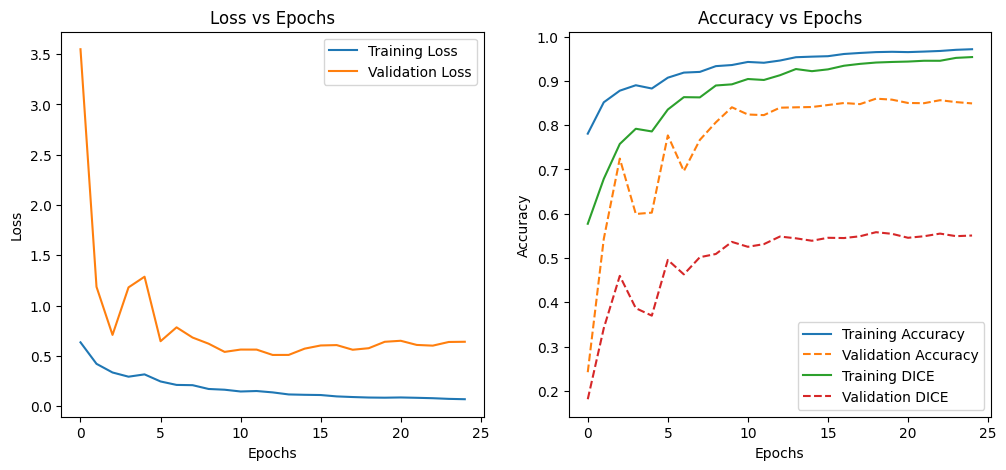

In [13]:
# Obtener los datos de 'loss' y 'accuracy' del objeto history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history.get('accuracy')  # 'accuracy' es la métrica de precisión
val_accuracy = history.history.get('val_accuracy')  # Precisión en validación
dice=history.history.get('dice_multiv2')
val_dice=history.history.get('val_dice_multiv2')
# Crear el gráfico de Loss vs Epochs
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy',linestyle='--')
plt.plot(dice, label='Training DICE')
plt.plot(val_dice, label='Validation DICE',linestyle='--')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Mostrar los gráficos
plt.show()

# Reconstruccion de imagenes

shape (1479, 2149, 3)
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


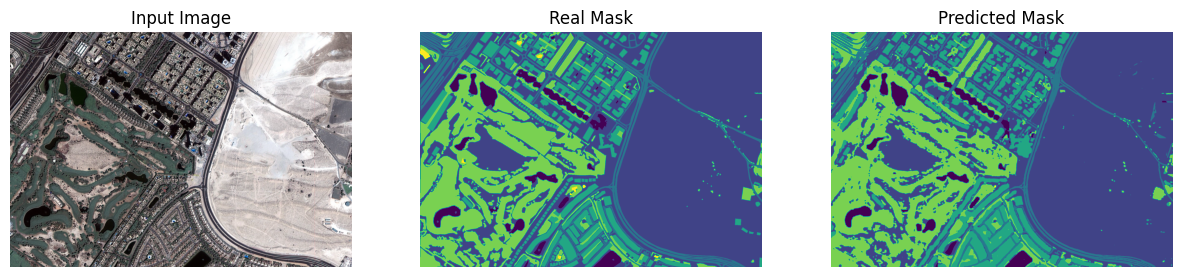

Accuracy 0.8778131942432146 : DICE 0.8778132200241089


In [11]:
model_load=Model(InputL, PredMask, name="DeepLabV3-Plus")
model_load.load_weights('../modelo-19-0.86_v2.weights.h5')

img=cv2.imread(data_path_images+'/Tile 8/images/image_part_001.jpg')
img_msk=cv2.imread(data_path_images+'/Tile 8/masks/image_part_001.png')
print(f'shape {img.shape}')
#realizar corte
trozos_imagen=obtener_corte(img)
#predicciones
preds=model_load.predict(trozos_imagen)
#pred_binary = (preds > 0.5).astype(np.uint8)
#pred_binary=np.argmax(preds,axis=-1)
#reconstruyo la prediccion
pred_mask_recon=reconstruir_imagen(preds,(img.shape[0],img.shape[1]),tipo='img')
# Mostrar las imágenes en filas de tres
#mask=(img_mask/255+(img_mask_road/255)*2)
#mask[mask==3]=1
pred_binary=np.argmax(pred_mask_recon,axis=-1)

plot_images_comparation([[img,color_to_2D_label(img_msk,type_='bgr',dict_clases=dict_clases),pred_binary]])
#fig, axs = plt.subplots(1, 3, figsize=(15, 5))
#for j in range(3):
#    axs[j].imshow([img,img_mask,pred_mask_recon][j])
#    axs[j].axis('off')
#    axs[j].set_title(["Input Image", "Ground Truth Mask", "Predicted Mask"][j])
#
#plt.show()
print(f'Accuracy {accuracy_score(color_to_2D_label(img_msk,dict_clases=dict_clases).flatten(),pred_binary.flatten())} : DICE {dice_multiv2(color_to_2D_label(img_msk,dict_clases=dict_clases),pred_mask_recon).numpy()}')